In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoConfig

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 1 HF_HOME: /local1/mohsenfayyaz/.hfcache/


# Download Dataset + DecompX Tensors

In [2]:
hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename="results/re-docred_facebook--contriever-msmarco_7170.pkl", repo_type="dataset", local_dir="hf/")

'hf/results/re-docred_facebook--contriever-msmarco_7170.pkl'

In [3]:
df_raw = pd.read_pickle("./hf/results/re-docred_facebook--contriever-msmarco_7170.pkl")
print(df_raw.attrs)
df_raw.head(3)

{'model': 'facebook/contriever-msmarco', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.441, 'NDCG@3': 0.48114, 'NDCG@5': 0.49109, 'NDCG@10': 0.50235, 'NDCG@100': 0.52957, 'NDCG@1000': 0.54767}, 'map': {'MAP@1': 0.441, 'MAP@3': 0.47134, 'MAP@5': 0.47683, 'MAP@10': 0.48152, 'MAP@100': 0.48636, 'MAP@1000': 0.48693}, 'recall': {'Recall@1': 0.441, 'Recall@3': 0.50948, 'Recall@5': 0.53375, 'Recall@10': 0.56834, 'Recall@100': 0.70404, 'Recall@1000': 0.85258}, 'precision': {'P@1': 0.441, 'P@3': 0.16983, 'P@5': 0.10675, 'P@10': 0.05683, 'P@100': 0.00704, 'P@1000': 0.00085}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_mean,query_decompx_tokenizer_word_ids,gold_doc_decompx_tokens,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_mean,gold_doc_decompx_tokenizer_word_ids,pred_doc_decompx_tokens,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_mean,pred_doc_decompx_tokenizer_word_ids
0,test0,When was Loud Tour published?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.5781064033508301, 'min'...",{'Loud Tour': 0.5781064033508301},"{'Loud Tour': 0.5781064033508301, 'Images and ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in,...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...",P577,publication date,When was Loud Tour published?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.578106,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.578106,142,142,"[[CLS], when, was, loud, tour, published, ?, [...","[-1.010608, 0.23060957, -0.025443379, 2.001933...","[[0.05046981, -0.012882221, 0.036922462, 0.014...","[None, 0, 1, 2, 3, 4, 4, None]","[[CLS], loud, tour, the, loud, tour, was, the,...","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[[CLS], loud, tour, the, loud, tour, was, the,...","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."
1,test1,Who performed Loud Tour?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.6464771032333374, 'min'...",{'Loud Tour': 0.6464771032333374},"{'Loud Tour': 0.6464771032333374, 'Live &amp; ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test1,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}",1,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [3, 4], 'sent_id':...","{Loud Tour, Loud}",{Rihanna},Loud Tour,Rihanna,{MISC},{PER},"[0, 1]","[[The, Loud, Tour, was, the, fourth, overall, ...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [18, 19], 'sent_id...",P175,performer,Who performed Loud Tour?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.646477,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.646477,142,142,"[[CLS], who, performed, loud, tour, ?, [SEP]]","[-1.2612208, 0.086274244, 0.24784759, 3.217437...","[[0.060550287, 0.

# Plot DecompRAG

In [4]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib

def print_importance(importance, tokenized_text, discrete=False, prefix=""):
    """
    importance: (sent_len)
    """
    assert len(importance) == len(tokenized_text)
    importance = importance / np.abs(importance).max() / 1.0  # Normalize
    if discrete:
        importance = np.argsort(np.argsort(importance)) / len(importance) / 1.6

    html = "<pre style='line-height: 28px; display: flex; flex-flow: row wrap;'>"+prefix
    for i in range(len(tokenized_text)):
        # if importance[i] > 0:
        #     rgba = plt.get_cmap('Reds')(importance[i] * .7)   # Wistia
        # else:
        #     rgba = plt.get_cmap('Greens')(np.abs(importance[i]) + .5)   # Wistia
        rgba = plt.get_cmap('coolwarm')((importance[i] + 1) / 2)
        text_color = "color: rgba(255, 255, 255, 1.0); " if np.abs(importance[i]) > 1 else "color: rgba(10, 10, 10, 1.0); "
        color = f"background-color: rgba({rgba[0]*255}, {rgba[1]*255}, {rgba[2]*255}, {rgba[3]}); " + text_color
        html += (f"<div style='"
                 f"{color}"
                 f"border-radius: 5px; padding: 2px; margin: 1px;"
                 f"font-weight: {int(800)};"
                 "width: fit-content; display: flex;"
                 "'>")
        html += tokenized_text[i].replace('<', "[").replace(">", "]")
        html += "</div> "
        if tokenized_text[i] in ["hypothesis,", "hold.", '"contradiction"']:
            html += '<br>'
    return html

def html_wrapper(htmls, desc="text", legend="?"):
    html = ""
    head = """
    <head>
    <style>
        @media print {
            -webkit-print-color-adjust: exact;
        }
        fieldset {
            max-width: 1000px; padding: 8px; border-radius: 20px; border: 3px solid rgb(15, 200, 200); background: white; color: black;
        }
        legend {
            margin-left: 10px; padding: 7px; padding-left: 20px; padding-right: 20px; border: 2px solid rgb(15, 200, 200);
            border-radius: 20px; background: white;
            /*font-family: Arial !important;*/
            font-weight: 600;
        }
        table tr td {
            white-space: nowrap; padding: 5px;
        }
    </style>
    </head>
    """
    html += head
    html += f"""
        <fieldset>
            <legend>{legend}</legend>
            <table style='width: 1000px; font-weight: 600; color: black;'>
            """
    for i in range(len(htmls)):
        html += """
        <tr>
        """
        html += f"<td style='text-align: center; width: 100px;'>{desc}:</td><td>"
        html += htmls[i]
        html += "</td></tr>"
    html += "</table></fieldset>"
    return html

Query:,[CLS] which country is columbia gorge waterfalls associated with ? [SEP]


Gold Doc:


Pred Doc:


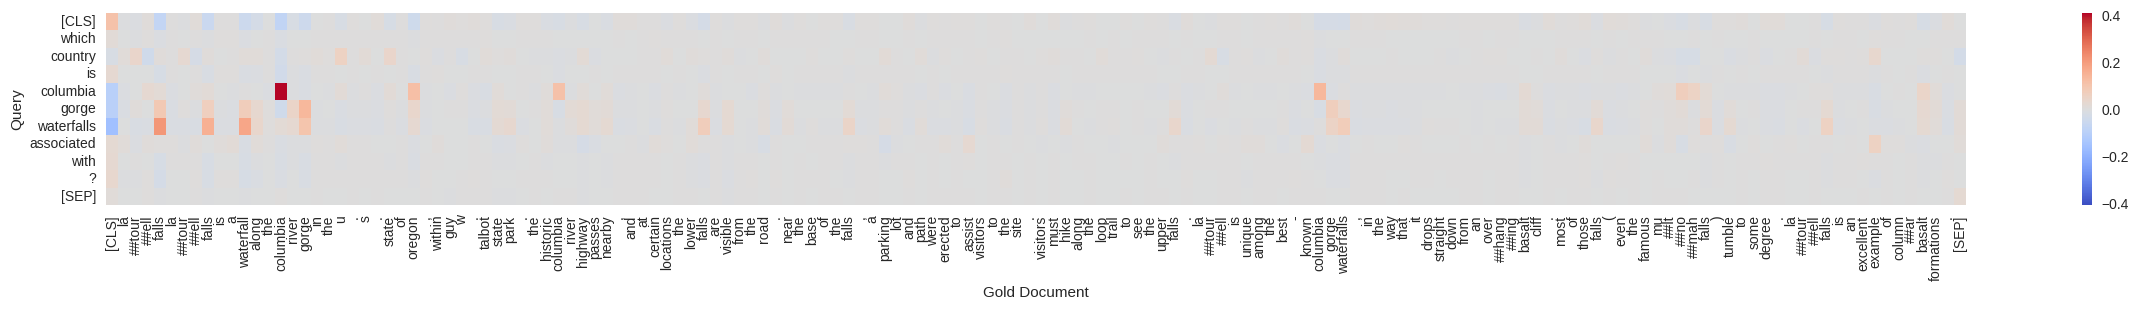

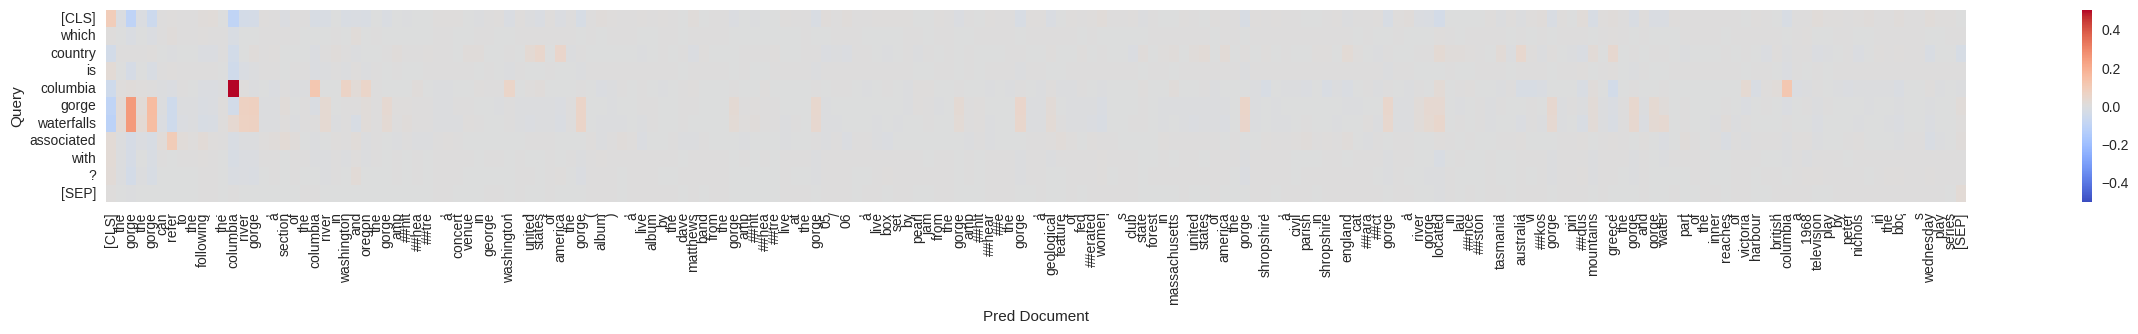

In [5]:
def plot_demo(df, idx):
    ### RUN/LOAD DECOMPX ON QUERY AND DOC
    query = {
        "tokens": df.loc[idx]["query_decompx_tokens"],
        "tokens_dot_scores": df.loc[idx]["query_decompx_tokens_dot_scores"],
        "decompx_last_layer_mean": df.loc[idx]["query_decompx_decompx_last_layer_mean"],
        "tokenizer_word_ids": df.loc[idx]["query_decompx_tokenizer_word_ids"],
    }
    gold_doc = {
        "tokens": df.loc[idx]["gold_doc_decompx_tokens"],
        "tokens_dot_scores": df.loc[idx]["gold_doc_decompx_tokens_dot_scores"],
        "decompx_last_layer_mean": df.loc[idx]["gold_doc_decompx_decompx_last_layer_mean"],
        "tokenizer_word_ids": df.loc[idx]["gold_doc_decompx_tokenizer_word_ids"],
    }
    pred_doc = {
        "tokens": df.loc[idx]["pred_doc_decompx_tokens"],
        "tokens_dot_scores": df.loc[idx]["pred_doc_decompx_tokens_dot_scores"],
        "decompx_last_layer_mean": df.loc[idx]["pred_doc_decompx_decompx_last_layer_mean"],
        "tokenizer_word_ids": df.loc[idx]["pred_doc_decompx_tokenizer_word_ids"],
    }
    head_entity = df.loc[idx]['head_entity_longest_name'] if 'head_entity_longest_name' in df.columns else '?'
    tail_entity = df.loc[idx]['tail_entity_longest_name'] if 'tail_entity_longest_name' in df.columns else '?'
    relation = df.loc[idx]['relation_name'] if 'relation_name' in df.columns else '?'
    split = df.loc[idx]['split'] if 'split' in df.columns else '?'
    
    ### PLOT MEAN DOT IMPORTANCE
    DATASET = df.attrs.get("dataset", "?")
    MODEL = df.attrs.get("model", "?")
    htmls = [print_importance(query["tokens_dot_scores"], query["tokens"])]
    final_html = html_wrapper(htmls, "Query", f"{DATASET}, {MODEL}, idx={idx}, (head={head_entity}, relation={relation}, tail={tail_entity})")
    display(HTML(final_html))
    htmls = [print_importance(gold_doc["tokens_dot_scores"], gold_doc["tokens"])]
    final_html = html_wrapper(htmls, "Gold Doc", f"{DATASET}, {MODEL}, idx={idx}, score={df.loc[idx]['gold_doc_score']}, hit_rank={df.loc[idx]['hit_rank']}")
    display(HTML(final_html))
    htmls = [print_importance(pred_doc["tokens_dot_scores"], pred_doc["tokens"])]
    final_html = html_wrapper(htmls, "Pred Doc", f"{DATASET}, {MODEL}, idx={idx}, score={df.loc[idx]['pred_doc_score']}")
    display(HTML(final_html))
    
    ### PLOT CROSS DOT IMPORTANCE
    from seaborn import heatmap
    import matplotlib.pyplot as plt
    
    def plot_qd_heatmap(query_tokens, query_decomposed, doc_tokens, doc_decomposed, xlabel="Doc", ylabel="Query"):
        with torch.no_grad():
            qd_scores = torch.einsum("id,jd->ij", torch.tensor(query_decomposed), torch.tensor(doc_decomposed)).cpu().numpy()
        plt.figure(figsize=(30, 2.5))  # 30 for debug 15 for aesthetics
        heatmap(qd_scores, cmap=plt.get_cmap('coolwarm'), vmin=-np.max(np.abs(qd_scores)), vmax=np.max(np.abs(qd_scores)))
        plt.xticks(np.arange(len(doc_tokens))+0.5, doc_tokens, rotation='vertical')
        plt.yticks(np.arange(len(query_tokens))+0.5, query_tokens, rotation='horizontal')
        plt.grid("on", linewidth=0.2); plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.show()
    
    plot_qd_heatmap(query["tokens"], query["decompx_last_layer_mean"], gold_doc["tokens"], gold_doc["decompx_last_layer_mean"], "Gold Document")
    plot_qd_heatmap(query["tokens"], query["decompx_last_layer_mean"], pred_doc["tokens"], pred_doc["decompx_last_layer_mean"], "Pred Document")
    
    
    ### PLOT SELF DECOMPX BLOCKS
    # from seaborn import heatmap
    # import matplotlib.pyplot as plt
    
    # def plot_decompx_heatmap(tokens, decompx_last_layer_outputs, label="?"):
    #     norm_heatmap = decompx_last_layer_outputs.aggregated[0][0].norm(dim=-1).cpu().numpy()
    #     heatmap(norm_heatmap / np.diag(norm_heatmap).reshape((-1, 1)), cmap=plt.get_cmap('Reds'))
    #     plt.xticks(np.arange(len(tokens))+0.5, tokens, rotation='vertical')
    #     plt.yticks(np.arange(len(tokens))+0.5, tokens, rotation='horizontal')
    #     plt.grid("on", linewidth=0.2); plt.xlabel(label); plt.ylabel(label)
    
    # plt.figure(figsize=(11, 3))
    # plt.subplot(1, 3, 1); plot_decompx_heatmap(query["tokens"], query["decompx_last_layer_outputs"], "Query")
    # plt.subplot(1, 3, 2); plot_decompx_heatmap(gold_doc["tokens"], gold_doc["decompx_last_layer_outputs"], "Gold Document")
    # plt.subplot(1, 3, 3); plot_decompx_heatmap(pred_doc["tokens"], pred_doc["decompx_last_layer_outputs"], "Pred Document")
    # plt.tight_layout()

plot_demo(df_raw, idx=95)  # 329, 1526

In [6]:
df_raw.sort_values("gold_doc_len").head(500).sample(frac=1)

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_mean,query_decompx_tokenizer_word_ids,gold_doc_decompx_tokens,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_mean,gold_doc_decompx_tokenizer_word_ids,pred_doc_decompx_tokens,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_mean,pred_doc_decompx_tokenizer_word_ids
5635,validation9147,Who owns Ici Paris?,[Ici Paris],{'Ici Paris': {'text': 'Ici Paris is a French ...,"{'len': 1000, 'max': 0.6937267184257507, 'min'...",{'Ici Paris': 0.6937267184257507},"{'Ici Paris': 0.6937267184257507, 'AccorHotels...",{'Ici Paris': {'text': 'Ici Paris is a French ...,validation9147,Ici Paris,"[[{'type': 'MISC', 'pos': [0, 2], 'name': 'Ici...","[{'r': 'P159', 'h': 6, 't': 4, 'evidence': [2]...","[[Ici, Paris, is, a, French, magazine, ,, foun...",validation,"{'r': 'P127', 'h': 0, 't': 3, 'evidence': [0, 1]}",3,"[{'type': 'MISC', 'pos': [0, 2], 'name': 'Ici ...","[{'name': 'Lagardère', 'pos': [5, 6], 'sent_id...",{Ici Paris},{Lagardère},Ici Paris,Lagardère,{MISC},{PER},"[0, 1]","[[Ici, Paris, is, a, French, magazine, ,, foun...","[{'type': 'MISC', 'pos': [0, 2], 'name': 'Ici ...","[{'name': 'Lagardère', 'pos': [5, 6], 'sent_id...",P127,owned by,Who owns Ici Paris?,0,{},1.0,"Ici Paris Ici Paris is a French magazine , fou...",Ici Paris,"Ici Paris is a French magazine , founded in 19...",0.693727,"Ici Paris Ici Paris is a French magazine , fou...",Ici Paris,"Ici Paris is a French magazine , founded in 19...",0.693727,135,135,"[[CLS], who, owns, ic, ##i, paris, ?, [SEP]]","[-0.7191502, 0.3991651, 1.0678113, 0.521008, 0...","[[0.04526133, 0.067301944, -0.061613254, 0.002...","[None, 0, 1, 2, 2, 3, 3, None]","[[CLS], ic, ##i, paris, ic, ##i, paris, is, a,...","[-0.16005227, 0.30177513, 0.20701268, 0.276702...","[[0.015871266, 0.015515315, 0.00035643004, -0....","[None, 0, 0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10,...","[[CLS], ic, ##i, paris, ic, ##i, paris, is, a,...","[-0.16005227, 0.30177513, 0.20701268, 0.276702...","[[0.015871266, 0.015515315, 0.00035643004, -0....","[None, 0, 0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10,..."
3974,validation1800,Which country is New Bohumín associated with?,[Bohumín],"{'Bohumín': {'text': 'Bohumín (; ; , ) is a to...","{'len': 1000, 'max': 0.6076632738113403, 'min'...",{'Bohumín': 0.6076632738113403},"{'Bohumín': 0.6076632738113403, 'Canada–New Ze...","{'Bohumín': {'text': 'Bohumín (; ; , ) is a to...",validation1800,Bohumín,"[[{'name': 'Bohumín', 'pos': [0, 1], 'sent_id'...","[{'r': 'P131', 'h': 1, 't': 2, 'evidence': [0]...","[[Bohumín, (;, ;, ,, ), is, a, town, in, Karvi...",validation,"{'r': 'P17', 'h': 9, 't': 3, 'evidence': [0, 3...",3,"[{'name': 'New Bohumín', 'pos': [7, 9], 'sent_...","[{'name': 'Czech Republic', 'pos': [17, 19], '...",{New Bohumín},{Czech Republic},New Bohumín,Czech Republic,{LOC},{LOC},"[0, 3, 6]","[[Bohumín, (;, ;, ,, ), is, a, town, in, Karvi...","[{'name': 'New Bohumín', 'pos': [7, 9], 'sent_...","[{'name': 'Czech Republic', 'pos': [17, 19], '...",P17,country,Which country is New Bohumín associated with?,0,{},1.0,"Bohumín Bohumín (; ; , ) is a town in Karviná ...",Bohumín,"Bohumín (; ; , ) is a town in Karviná District...",0.607663,"Bohumín Bohumín (; ; , ) is a town in Karviná ...",Bohumín,"Bohumín (; ; , ) is a town in Karviná District...",0.607663,133,133,"[[CLS], which, country, is

# Real-Time DecompX (Can Skip)

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML
import transformers
from transformers import AutoTokenizer, AutoConfig

from DecompX.src.decompx_utils import DecompXConfig
from DecompX.src.modeling_bert import BertForSequenceClassification, BertModel
from DecompX.src.modeling_roberta import RobertaForSequenceClassification, RobertaModel

DATASET = df_raw.attrs.get("dataset", "?")
MODEL = df_raw.attrs.get("model", "?")  # 'facebook/contriever-msmarco'  # Only BERT or RoBERTa
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONFIGS = {
    "DecompX":
        DecompXConfig(
            include_biases=True,
            bias_decomp_type="absdot",
            include_LN1=True,
            include_FFN=True,
            FFN_approx_type="GeLU_ZO",
            include_LN2=True,
            aggregation="vector",
            include_classifier_w_pooler=True,
            tanh_approx_type="ZO",
            output_all_layers=True,
            output_attention=None,
            output_res1=None,
            output_LN1=None,
            output_FFN=None,
            output_res2=None,
            output_encoder=None,
            output_aggregated="vector",  # Changed
            output_pooler="norm",
            output_classifier=True,
        ),
}

def load_model_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model_config = AutoConfig.from_pretrained(model_name)
    if type(model_config) is transformers.models.roberta.configuration_roberta.RobertaConfig:
        model = RobertaModel.from_pretrained(model_name)
    elif type(model_config) is transformers.models.bert.configuration_bert.BertConfig:
        model = BertModel.from_pretrained(model_name)
    else:
        raise Exception(f"Not implemented model: {model_name}")
    model.to(DEVICE)
    return model, tokenizer

model, tokenizer = load_model_tokenizer(MODEL)

In [ ]:
def run_decompx(text):
    text = text.split()
    inputs = tokenizer([text], padding=True, truncation=True, return_tensors='pt', is_split_into_words=True)
    input_ids = inputs["input_ids"]
    inputs.to(model.device)
    with torch.no_grad():
        last_hidden_states, pooler_output, hidden_states, decompx_last_layer_outputs, decompx_all_layers_outputs = model(
            **inputs,
            output_attentions=False,
            return_dict=False,
            output_hidden_states=True,
            decompx_config=CONFIGS["DecompX"]
        )
        ### decompx_last_layer_outputs.aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim] ###
        ### last_hidden_states ~ [1, 70, 768] ~ [batch, seq_len, emb_dim]
        # print(last_hidden_states.shape)  # 
        mean_pooled = last_hidden_states[0].mean(dim=0)
        decompx_last_layer_mean = decompx_last_layer_outputs.aggregated[0][0].mean(dim=(0))  # Mean over DecompX similar to the retriever [seq_len, emb_dim]
        tokens_dot_scores = torch.einsum("ij,j->i", decompx_last_layer_mean, mean_pooled)  # [seq_len]
        ranking = torch.argsort(tokens_dot_scores, descending=True).cpu().numpy()
    return {
        "tokens": tokenizer.convert_ids_to_tokens(input_ids[0]),  # [seq_len]
        "tokens_dot_scores": tokens_dot_scores.cpu().numpy(),  # [seq_len]  (Dot score with mean)
        # "decompx_last_layer_outputs": decompx_last_layer_outputs.aggregated[0][0].cpu().numpy(),  # .aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim]
        "decompx_last_layer_mean": decompx_last_layer_mean.cpu().numpy(),  # [seq_len, emb_dim]
        "tokenizer_word_ids": inputs.word_ids(),  # [seq_len]
    }

# Finding Tokenized Position of Entities

In [8]:
from unidecode import unidecode

def find_head_tail_tokens(df, idx, verbose=False):
    def vprint(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
    ### Load Tokenizer
    # tokenizer = AutoTokenizer.from_pretrained("facebook/contriever-msmarco")
    ### RUN/LOAD DECOMPX ON QUERY AND DOC
    query = {
        "tokens": np.array(df.loc[idx]["query_decompx_tokens"]),
        "tokens_dot_scores": df.loc[idx]["query_decompx_tokens_dot_scores"],
        "decompx_last_layer_mean": df.loc[idx]["query_decompx_decompx_last_layer_mean"],
        "tokenizer_word_ids": df.loc[idx]["query_decompx_tokenizer_word_ids"],
    }
    gold_doc = {
        "tokens": np.array(df.loc[idx]["gold_doc_decompx_tokens"]),
        "tokens_dot_scores": df.loc[idx]["gold_doc_decompx_tokens_dot_scores"],
        "decompx_last_layer_mean": df.loc[idx]["gold_doc_decompx_decompx_last_layer_mean"],
        "tokenizer_word_ids": df.loc[idx]["gold_doc_decompx_tokenizer_word_ids"],
    }
    # gold_doc = run_decompx(df.loc[idx]["gold_doc"])
    # gold_doc["tokens"] = np.array(gold_doc["tokens"])
    
    # pred_doc = {
    #     "tokens": df.loc[idx]["pred_doc_decompx_tokens"],
    #     "tokens_dot_scores": df.loc[idx]["pred_doc_decompx_tokens_dot_scores"],
    #     "decompx_last_layer_mean": df.loc[idx]["pred_doc_decompx_decompx_last_layer_mean"],
    #     "tokenizer_word_ids": df.loc[idx]["pred_doc_decompx_tokenizer_word_ids"],
    # }
    sent_len_accumulated = [0]
    for sent in df.loc[idx]["sents"]:
        sent_len_accumulated.append(len(sent) + sent_len_accumulated[-1])
        
    words = np.array([w for sent in df.loc[idx]["sents"] for w in sent])
    tokenizer_skipped_chars = [" ", '\xa0']
    hyphen_chars_accumulated = [1 if words[0] in tokenizer_skipped_chars else 0]
    for w in words[1:]:
        hyphen_chars_accumulated.append(hyphen_chars_accumulated[-1] + 1 if w in tokenizer_skipped_chars else hyphen_chars_accumulated[-1])
    # vprint("hyphen_chars_accumulated", hyphen_chars_accumulated, len(hyphen_chars_accumulated))
    # vprint("words", words, len(words))
    # title_len = max(tokenizer([df.loc[idx]["title"]], padding=False, truncation=True, return_tensors='pt').word_ids()[1:-1]) + 1
    title_len = len(df.loc[idx]["title"].split())
    
    def find_entity(entity):
        global_pos = np.array([
            sent_len_accumulated[entity["sent_id"]] + entity["pos"][0], 
            sent_len_accumulated[entity["sent_id"]] + entity["pos"][1]
        ])
        
        # assert " ".join(words[global_pos[0]:global_pos[1]]) == entity["name"]
        if " ".join(words[global_pos[0]:global_pos[1]]).replace(" ", "") != entity["name"].replace(" ", ""):
            print(f"{idx} WARNING1:", " ".join(words[global_pos[0]:global_pos[1]]), "!=", entity["name"])
        
        ### FIX \xa0 and ' '
        global_pos[0] -= hyphen_chars_accumulated[global_pos[0]]
        global_pos[1] -= hyphen_chars_accumulated[global_pos[1] - 1]
        ### FIX TITLE
        global_pos += title_len
        
        tokenizer_word_ids = np.array(gold_doc["tokenizer_word_ids"])
        tokenizer_word_ids[tokenizer_word_ids == None] = -1
        # vprint("tokenizer_word_ids, global_pos", tokenizer_word_ids, global_pos)
        token_pos = np.where(np.logical_and(tokenizer_word_ids>=global_pos[0], tokenizer_word_ids<global_pos[1]))[0]
        # print("head_token_pos", head_token_pos)
        # vprint("tokens", gold_doc["tokens"])
        # vprint(entity)
        # vprint("\n####tokens selected", gold_doc["tokens"][token_pos], "\n\n")
        
        a = []; b = []
        for word_id, token in zip(tokenizer_word_ids, gold_doc["tokens"]):
            a.append(f"[{word_id}]{token}")
        for i, w in enumerate(words):
            b.append(f"[{i + title_len}]{w}")
        # vprint(np.array(b))
        # vprint(np.array(a))
        
        # assert("".join(gold_doc["tokens"][token_pos]).lower().replace("#", "") == entity["name"].replace(" ", "").lower())
        if unidecode("".join(gold_doc["tokens"][token_pos]).lower().replace("#", "")) != unidecode(entity["name"].replace(" ", "").replace("\xa0", "").lower()):
            print(f"{idx} WARNING2:", "".join(gold_doc["tokens"][token_pos]).lower().replace("#", ""), "!=", entity["name"].replace(" ", "").replace("\n", "").lower(), len(words))
        return token_pos
    
    def find_query_head_tokens(row):
        def find_sub_list(sl,l):
            results=[]
            sll=len(sl)
            for ind in (i for i,e in enumerate(l) if e==sl[0]):
                if l[ind:ind+sll]==sl:
                    results.append((ind,ind+sll))
            return results
        vprint(row["query"])
        head_in_query_str_list = row["head_entity_longest_name"].split()
        query_str_list = row["query"].replace("?", "", 1).split()  # "when was head?" and head can have ? in itself! idx=6270
        vprint("head_in_query_str_list", head_in_query_str_list)
        vprint("query_str_list", query_str_list)
        query_head_pos = find_sub_list(head_in_query_str_list, query_str_list)[0]
        vprint("query_head_pos", query_head_pos)
        tokenizer_word_ids = np.array(query["tokenizer_word_ids"])
        tokenizer_word_ids[tokenizer_word_ids == None] = -1
        token_pos = np.where(np.logical_and(tokenizer_word_ids>=query_head_pos[0], tokenizer_word_ids<query_head_pos[1]))[0]
        if query["tokens"][token_pos[-1]] == "?":
            token_pos = token_pos[:-1]
        vprint("token_pos", token_pos)
        vprint("tokens", query["tokens"])
        vprint("word_ids", tokenizer_word_ids)
        vprint(query["tokens"][token_pos])
        if unidecode("".join(query["tokens"][token_pos]).lower().replace("#", "")) != unidecode(row["head_entity_longest_name"].replace(" ", "").replace("\xa0", "").lower()):
            print(f"{idx} WARNING2:", unidecode("".join(query["tokens"][token_pos]).lower().replace("#", "")), "!=", unidecode(row["head_entity_longest_name"].replace(" ", "").replace("\xa0", "").lower()))
        return token_pos
        
    
    head_global_pos = []
    tail_global_pos = []
    for head_entity in df.loc[idx]['head_entity']:
        head_global_pos.extend(find_entity(head_entity))
    for tail_entity in df.loc[idx]['tail_entity']:  # in evidence or not?
        tail_global_pos.extend(find_entity(tail_entity))
    
    return {
        "heads_pos": head_global_pos,
        "tails_pos": tail_global_pos,
        "query_head_pos": find_query_head_tokens(df.loc[idx])
    }
    
    
find_head_tail_tokens(df_raw, 6270, verbose=True)  # 1526

Who performed Is It True ??
head_in_query_str_list ['Is', 'It', 'True', '?']
query_str_list ['Who', 'performed', 'Is', 'It', 'True', '?']
query_head_pos (2, 6)
token_pos [3 4 5 6]
tokens ['[CLS]' 'who' 'performed' 'is' 'it' 'true' '?' '?' '[SEP]']
word_ids [-1 0 1 2 3 4 5 5 -1]
['is' 'it' 'true' '?']


{'heads_pos': [np.int64(186), np.int64(187), np.int64(188), np.int64(189)],
 'tails_pos': [np.int64(181), np.int64(182), np.int64(183)],
 'query_head_pos': array([3, 4, 5, 6])}

In [9]:
### ADD HEAD AND TAIL AND QUERY_HEAD TOKEN POSITIONS TO THE DATAFRAME
df = df_raw.copy()
new_cols = {}
for idx in tqdm(range(len(df))):
    head_tail_pos = find_head_tail_tokens(df_raw, idx, verbose=False)
    for k, v in head_tail_pos.items():
        new_cols[k] = new_cols.get(k, []) + [v]
for k, v in new_cols.items():
    print("NEW COLUMN:", k)
    df[k] = v

# Remove empty heads and tails (Only 1 case)
df = df[df["heads_pos"].str.len() > 0]
df = df[df["tails_pos"].str.len() > 0]

df

  0%|          | 0/7170 [00:00<?, ?it/s]

68 WARNING2: [unk]崎二郎,shiizakijiro != 椎崎二郎,shiizakijirō 262
68 WARNING2: [unk]Qi Er Lang ,shiizakijiro != Zhui Qi Er Lang ,shiizakijiro
69 WARNING2: [unk]崎二郎,shiizakijiro != 椎崎二郎,shiizakijirō 262
69 WARNING2: [unk]Qi Er Lang ,shiizakijiro != Zhui Qi Er Lang ,shiizakijiro
70 WARNING2: [unk]崎二郎,shiizakijiro != 椎崎二郎,shiizakijirō 262
70 WARNING2: [unk]Qi Er Lang ,shiizakijiro != Zhui Qi Er Lang ,shiizakijiro
71 WARNING2: [unk]崎二郎,shiizakijiro != 椎崎二郎,shiizakijirō 262
71 WARNING2: [unk]Qi Er Lang ,shiizakijiro != Zhui Qi Er Lang ,shiizakijiro
77 WARNING2: [unk]崎二郎,shiizakijiro != 椎崎二郎,shiizakijirō 262
77 WARNING2: [unk]Qi Er Lang ,shiizakijiro != Zhui Qi Er Lang ,shiizakijiro
319 WARNING2:  != spacex 474
320 WARNING2:  != spacex 474
421 WARNING2: 江[unk][unk] != 江采蘋 423
717 WARNING2: [unk] != ადამაშვილი 159
718 WARNING2: [unk] != ადამაშვილი 159
1083 WARNING1: Live in New York != 0.
Live in New York
1083 WARNING2: liveinnewyork != 0.liveinnewyork 254
1083 WARNING2: 0.liveinnewyork != 0.
livei

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_mean,query_decompx_tokenizer_word_ids,gold_doc_decompx_tokens,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_mean,gold_doc_decompx_tokenizer_word_ids,pred_doc_decompx_tokens,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_mean,pred_doc_decompx_tokenizer_word_ids,heads_pos,tails_pos,query_head_pos
0,test0,When was Loud Tour published?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.5781064033508301, 'min'...",{'Loud Tour': 0.5781064033508301},"{'Loud Tour': 0.5781064033508301, 'Images and ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in,...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...",P577,publication date,When was Loud Tour published?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.578106,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.578106,142,142,"[[CLS], when, was, loud, tour, published, ?, [...","[-1.010608, 0.23060957, -0.025443379, 2.001933...","[[0.05046981, -0.012882221, 0.036922462, 0.014...","[None, 0, 1, 2, 3, 4, 4, None]","[[CLS], loud, tour, the, loud, tour, was, the,...","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[[CLS], loud, tour, the, loud, tour, was, the,...","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[47, 142, 143, 4, 5, 75, 76]",[49],"[3, 4]"
1,test1,Who performed Loud Tour?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.6464771032333374, 'min'...",{'Loud Tour': 0.6464771032333374},"{'Loud Tour': 0.6464771032333374, 'Live &amp; ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test1,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}",1,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [3, 4], 'sent_id':...","{Loud Tour, Loud}",{Rihanna},Loud Tour,Rihanna,{MISC},{PER},"[0, 1]","[[The, Loud, Tour, was, the, fourth, overall, ...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [18, 19], 'sent_id...",P175,performer,Who performed Loud Tour?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.646477,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.646477,142,142,"[[CLS], who, performed, loud, tour, ?

In [10]:
### MAX AND SUM HEAD TAIL ATTN
qd_op = np.sum
head_tail_op = np.sum
all_tokens_op = np.sum
divide = False

df["qd_scores"] = df.apply(lambda row: torch.einsum("id,jd->ij", torch.tensor(row["query_decompx_decompx_last_layer_mean"]), torch.tensor(row["gold_doc_decompx_decompx_last_layer_mean"])).cpu().numpy(), axis=1)
df["qd_scores_op"] = df.apply(lambda row: qd_op(row["qd_scores"], axis=0), axis=1)
df["qd_scores_head"] = df.apply(lambda row: qd_op(row["qd_scores"][row["query_head_pos"], :], axis=0), axis=1)
df["qd_scores_relation"] = df.apply(lambda row: qd_op(np.delete(row["qd_scores"], row["query_head_pos"], axis=0)[1:-1], axis=0), axis=1)
print(df.iloc[0]["qd_scores_head"].shape, df.iloc[0]["qd_scores_relation"].shape)

if divide:
    df["heads_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_op"][row["heads_pos"]]) / all_tokens_op(row["qd_scores_op"]), axis=1)
    df["tails_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_op"][row["tails_pos"]]) / all_tokens_op(row["qd_scores_op"]), axis=1)
    df["heads_attn_selfdot"] = df.apply(lambda row: head_tail_op(row["gold_doc_decompx_tokens_dot_scores"][row["heads_pos"]]) / all_tokens_op(row["gold_doc_decompx_tokens_dot_scores"]), axis=1)
    df["tails_attn_selfdot"] = df.apply(lambda row: head_tail_op(row["gold_doc_decompx_tokens_dot_scores"][row["tails_pos"]]) / all_tokens_op(row["gold_doc_decompx_tokens_dot_scores"]), axis=1)
    df["query_head_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_head"]) / all_tokens_op(row["qd_scores_op"]), axis=1)
    df["query_relation_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_relation"]) / all_tokens_op(row["qd_scores_op"]), axis=1)
else:
    df["heads_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_op"][row["heads_pos"]]), axis=1)
    df["tails_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_op"][row["tails_pos"]]), axis=1)
    df["heads_attn_selfdot"] = df.apply(lambda row: head_tail_op(row["gold_doc_decompx_tokens_dot_scores"][row["heads_pos"]]), axis=1)
    df["tails_attn_selfdot"] = df.apply(lambda row: head_tail_op(row["gold_doc_decompx_tokens_dot_scores"][row["tails_pos"]]), axis=1)
    df["query_head_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_head"]), axis=1)
    df["query_relation_attn_qd"] = df.apply(lambda row: head_tail_op(row["qd_scores_relation"]), axis=1)

df

(155,) (155,)


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_mean,query_decompx_tokenizer_word_ids,gold_doc_decompx_tokens,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_mean,gold_doc_decompx_tokenizer_word_ids,pred_doc_decompx_tokens,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_mean,pred_doc_decompx_tokenizer_word_ids,heads_pos,tails_pos,query_head_pos,qd_scores,qd_scores_op,qd_scores_head,qd_scores_relation,heads_attn_qd,tails_attn_qd,heads_attn_selfdot,tails_attn_selfdot,query_head_attn_qd,query_relation_attn_qd
0,test0,When was Loud Tour published?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.5781064033508301, 'min'...",{'Loud Tour': 0.5781064033508301},"{'Loud Tour': 0.5781064033508301, 'Images and ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in,...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...",P577,publication date,When was Loud Tour published?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.578106,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.578106,142,142,"[[CLS], when, was, loud, tour, published, ?, [...","[-1.010608, 0.23060957, -0.025443379, 2.001933...","[[0.05046981, -0.012882221, 0.036922462, 0.014...","[None, 0, 1, 2, 3, 4, 4, None]","[[CLS], loud, tour, the, loud, tour, was, the,...","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[[CLS], loud, tour, the, loud, tour, was, the,...","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[47, 142, 143, 4, 5, 75, 76]",[49],"[3, 4]","[[0.30964455, -0.712886, -0.013142059, 0.03303...","[-0.19506332, 0.5661381, 0.1324479, -0.0176743...","[-0.77891374, 1.8093113, 0.27102107, -0.104549...","[0.25808728, -0.5222644, -0.11117209, 0.050949...",0.830905,0.013935,0.875421,0.025883,2.317676,-0.242699
1,test1,Who performed Loud Tour?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.6464771032333374, 'min'...",{'Loud Tour': 0.6464771032333374},"{'Loud Tour': 0.6464771032333374, 'Live &amp; ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test1,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}",1,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [3, 4], 'sent_id':...","{Loud Tour, Loud}",{Rihanna},Loud Tour,Rihanna,{MISC},{PER},"[0, 1]","[[The, Loud, Tour, was, the, fourth, overall, ...","[{'name'

# CORR: Gold Doc Score vs head/tail/relation attn

In [ ]:
### CORR: Gold Doc Score vs head/tail/relation attn

dfc = df.copy()
dfc["hit_rank_quantized"] = dfc["hit_rank"].apply(lambda x: 0 if x < 5 else 1 if x <= 50 else 2 if x <= 100 else 3)
# dfc = dfc[["tails_attn_qd", "heads_attn_qd", "gold_doc_score"]]
# dfc.fillna(0, inplace=True)
dfc.dropna(inplace=True)
# dfc.plot.scatter(y="gold_doc_score", x="tails_attn_qd", figsize=(6, 4), s=0.1, xlim=(-0.1, 0.3))
# dfc.plot.scatter(y="gold_doc_score", x="heads_attn_qd", figsize=(6, 4), s=0.1, c="hit_rank_quantized")
# sns.scatterplot(data=dfc, y="gold_doc_score", x="heads_attn_qd", hue="hit_rank_quantized", s=10)
# sns.regplot(data=dfc, x="heads_attn_qd", y="gold_doc_score")


def plot_jointplot(dfc, x, y):
    plt.figure(figsize=(6, 4))
    g = sns.jointplot(data=dfc, x=x, y=y, kind="reg", ci=99, scatter_kws={'s': 2})
    r, p = stats.pearsonr(x=dfc[x], y=dfc[y])
    phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
    g.ax_joint.legend([phantom],[f"perasonr={r:.2f}, pvalue={p:.2f}"])
    plt.suptitle(f"qd_op={qd_op.__name__}, head_tail_op={head_tail_op.__name__}, all_tokens_op={all_tokens_op.__name__}, divide={divide}",)
    plt.tight_layout()


plot_jointplot(dfc, x="heads_attn_qd", y="gold_doc_score")
plot_jointplot(dfc, x="tails_attn_qd", y="gold_doc_score")

plot_jointplot(dfc, x="heads_attn_selfdot", y="gold_doc_score")
plot_jointplot(dfc, x="tails_attn_selfdot", y="gold_doc_score")

plot_jointplot(dfc, x="query_head_attn_qd", y="gold_doc_score")
plot_jointplot(dfc, x="query_relation_attn_qd", y="gold_doc_score")

# Attn BoxPlot

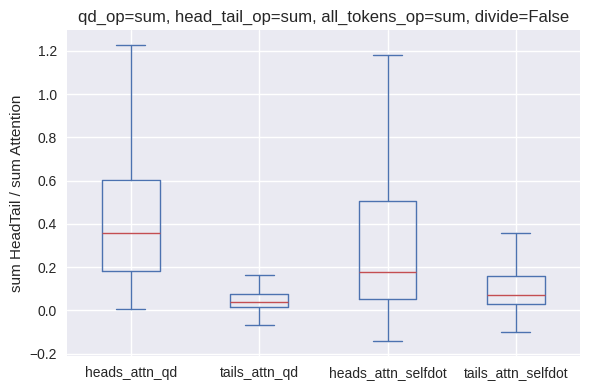

In [12]:
df[["heads_attn_qd", "tails_attn_qd", "heads_attn_selfdot", "tails_attn_selfdot"]].plot.box(
    figsize=(6, 4), 
    title=f"qd_op={qd_op.__name__}, head_tail_op={head_tail_op.__name__}, all_tokens_op={all_tokens_op.__name__}, divide={divide}",
    showfliers=False,
)
plt.ylabel(f"{head_tail_op.__name__} HeadTail / {all_tokens_op.__name__} Attention")
plt.tight_layout()
plt.show()

# Head/Tail Attn per Entity Type

In [18]:
df

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_mean,query_decompx_tokenizer_word_ids,gold_doc_decompx_tokens,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_mean,gold_doc_decompx_tokenizer_word_ids,pred_doc_decompx_tokens,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_mean,pred_doc_decompx_tokenizer_word_ids,heads_pos,tails_pos,query_head_pos,qd_scores,qd_scores_op,qd_scores_head,qd_scores_relation,heads_attn_qd,tails_attn_qd,heads_attn_selfdot,tails_attn_selfdot,query_head_attn_qd,query_relation_attn_qd
0,test0,When was Loud Tour published?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.5781064033508301, 'min'...",{'Loud Tour': 0.5781064033508301},"{'Loud Tour': 0.5781064033508301, 'Images and ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in,...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...",P577,publication date,When was Loud Tour published?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.578106,Loud Tour The Loud Tour was the fourth overall...,Loud Tour,The Loud Tour was the fourth overall and third...,0.578106,142,142,"[[CLS], when, was, loud, tour, published, ?, [...","[-1.010608, 0.23060957, -0.025443379, 2.001933...","[[0.05046981, -0.012882221, 0.036922462, 0.014...","[None, 0, 1, 2, 3, 4, 4, None]","[[CLS], loud, tour, the, loud, tour, was, the,...","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[[CLS], loud, tour, the, loud, tour, was, the,...","[-0.3229561, 0.57982266, 0.16577175, -0.032789...","[[0.015905423, 0.015761057, 0.015026314, 0.014...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[47, 142, 143, 4, 5, 75, 76]",[49],"[3, 4]","[[0.30964455, -0.712886, -0.013142059, 0.03303...","[-0.19506332, 0.5661381, 0.1324479, -0.0176743...","[-0.77891374, 1.8093113, 0.27102107, -0.104549...","[0.58385044, -1.2431731, -0.13857315, 0.086875...",0.830905,0.013935,0.875421,0.025883,2.317676,-0.849747
1,test1,Who performed Loud Tour?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.6464771032333374, 'min'...",{'Loud Tour': 0.6464771032333374},"{'Loud Tour': 0.6464771032333374, 'Live &amp; ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test1,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}",1,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [3, 4], 'sent_id':...","{Loud, Loud Tour}",{Rihanna},Loud Tour,Rihanna,{MISC},{PER},"[0, 1]","[[The, Loud, Tour, was, the, fourth, overall, ...","[{'name'

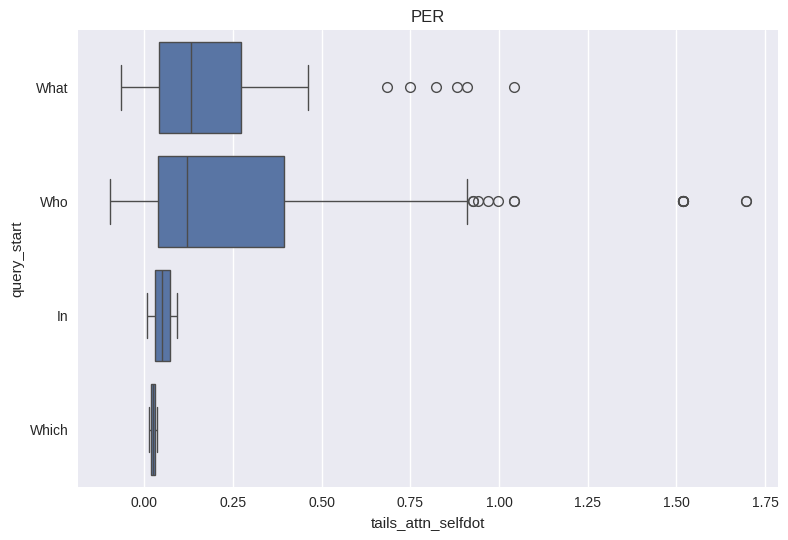

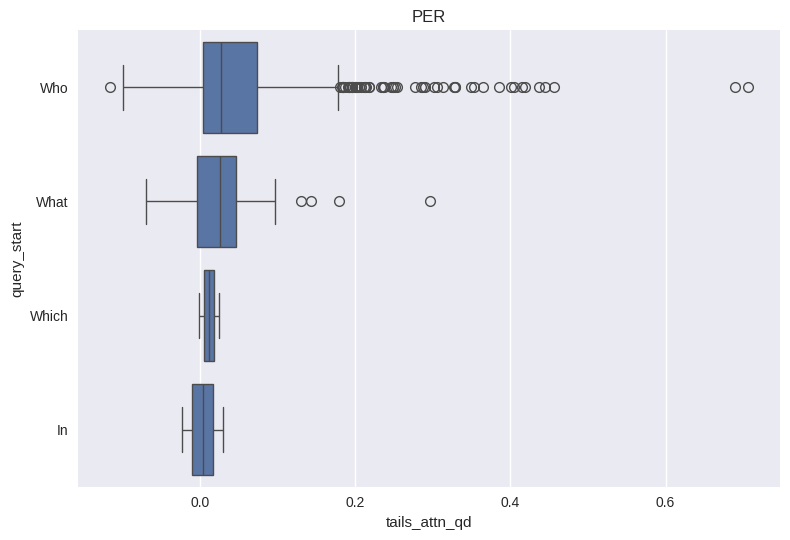

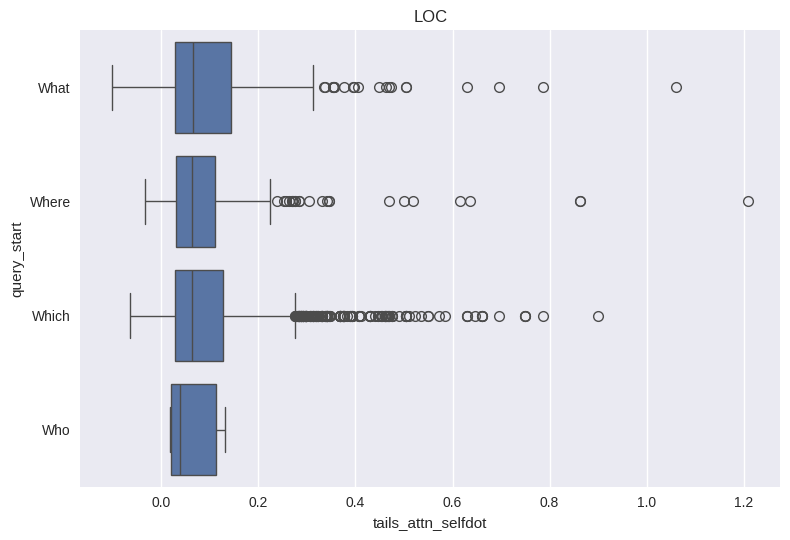

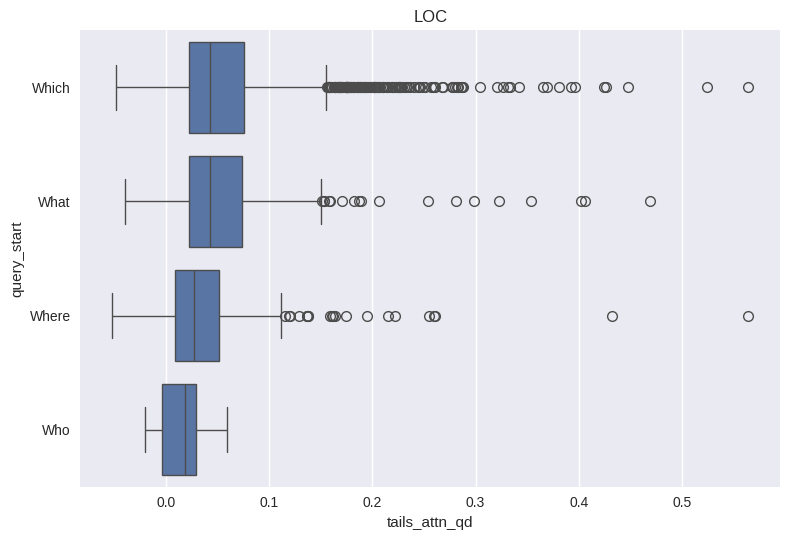

In [38]:
for r in ["PER", "LOC"]:
    df2 = df.copy()
    df2 = df2[df2["tail_entity_types"].apply(lambda x: r in x)]
    df2["query_start"] = df2["query"].apply(lambda x: " ".join(x.split()[:1]))
    # df2.plot.scatter(y="tails_attn_qd", x="tails_attn_selfdot", figsize=(6, 4), s=0.5, xlim=(-0.1, 0.6), ylim=(-0.1, 0.6))
    boxplot_ordered(df2, "query_start", "tails_attn_selfdot", True)
    plt.title(r)
    plt.tight_layout()
    plt.show()

    boxplot_ordered(df2, "query_start", "tails_attn_qd", True)
    plt.title(r)
    plt.tight_layout()
    plt.show()

# df2[["query", "gold_doc", "head_entity_names", "tail_entity_names", "tail_entity_types", "relation_name", "tails_attn_qd", "tails_attn_selfdot"]]

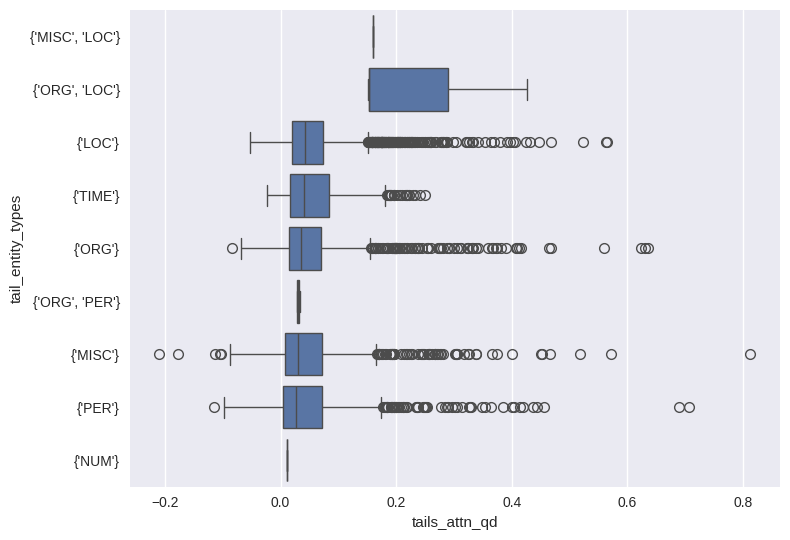

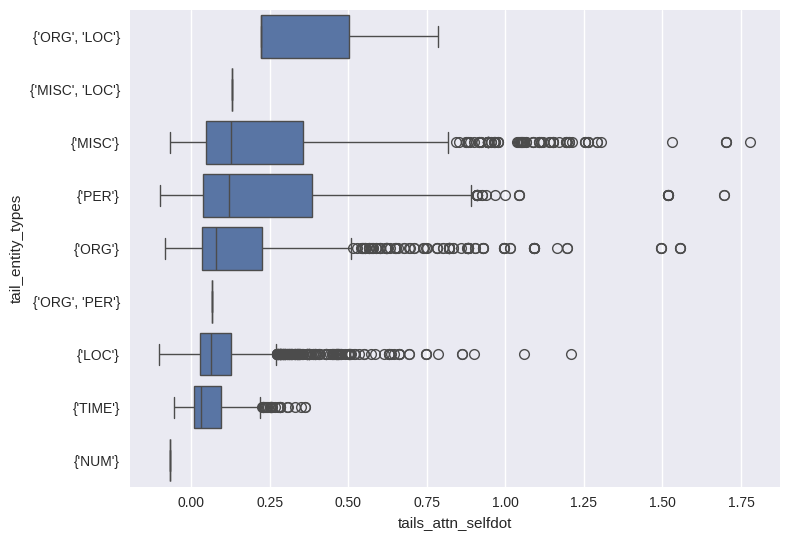

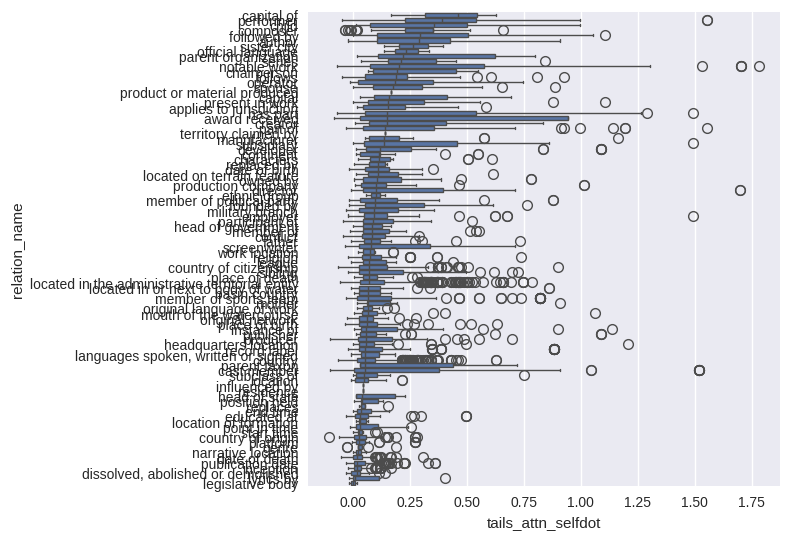

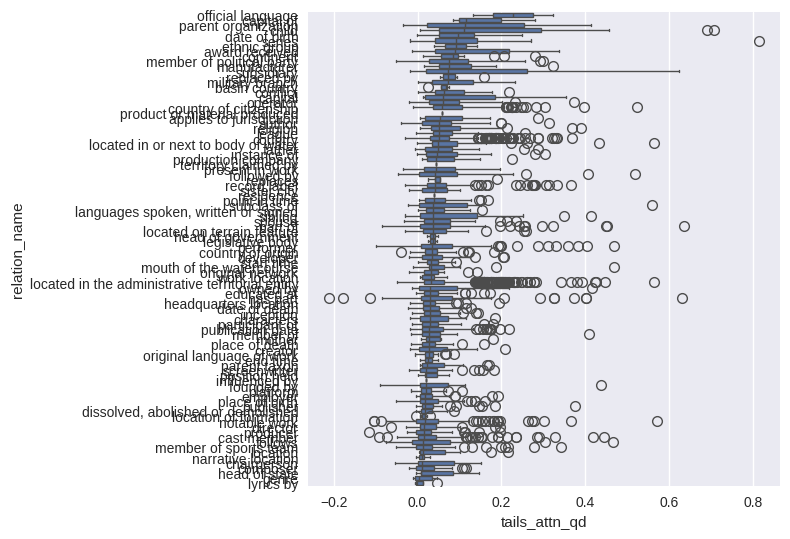

In [26]:
df2 = df[["head_entity_types", "tail_entity_types", "heads_attn_qd", "tails_attn_qd", "heads_attn_selfdot", "tails_attn_selfdot", "relation_name"]].copy()
df2["head_entity_types"] = df2["head_entity_types"].astype(str)
df2["tail_entity_types"] = df2["tail_entity_types"].astype(str)

def boxplot_ordered(dfc, x, y, rotate=False):
    grouped = dfc.loc[:,[x, y]].groupby([x]).median().sort_values(by=y, ascending=False)
    if not rotate:
        sns.boxplot(x=dfc[x], y=dfc[y], order=grouped.index)
    else:
        sns.boxplot(x=dfc[y], y=dfc[x], order=grouped.index)

# boxplot_ordered(df2, "head_entity_types", "heads_attn_qd", True)
# plt.tight_layout()
# plt.show()

boxplot_ordered(df2, "tail_entity_types", "tails_attn_qd", True)
plt.tight_layout()
plt.show()

# boxplot_ordered(df2, "head_entity_types", "heads_attn_selfdot", True)
# plt.tight_layout()
# plt.show()

boxplot_ordered(df2, "tail_entity_types", "tails_attn_selfdot", True)
plt.tight_layout()
plt.show()

boxplot_ordered(df2, "relation_name", "tails_attn_selfdot", True)
plt.tight_layout()
plt.show()

boxplot_ordered(df2, "relation_name", "tails_attn_qd", True)
plt.tight_layout()
plt.show()

# More

In [ ]:
import seaborn as sns

df["head_entity_len"] = df["head_entity"].str.len()
df["tail_entity_len"] = df["tail_entity"].str.len()
sns.boxplot(data=df, x="head_entity_len", y="gold_doc_score")
plt.show()
sns.boxplot(data=df, x="tail_entity_len", y="gold_doc_score")
